# Progetto di Social Computing

a.a. 2022/2023

## Attività preliminari

### Librerie e costanti

In [1]:
# Import delle librerie utilizzate
import os, tweepy, json
import networkx as nx 
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from pyvis.network import Network
from pylab import rcParams


In [2]:
# Cartelle di salvataggio
data_folder = "./data"
out_folder = "./out"
graph_folder = "./graphs"

### Funzioni

In [3]:
# Salvataggio in locale
def serialize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    
    with open(f"{folder}/{filename}", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent = 4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}")

In [4]:
# Lettura da locale
def read_json(path):
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as file:
            data = json.load(file)
        print(f"Data read from path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

### Credenziali Twitter API

In [5]:
# Caricamento credenziali da JSON
api_access = read_json("./api_access.json")

Data read from path: ./api_access.json


## Recupero dei follower e dei follower dei follower

### Recupero dei follower

Si vogliono recuperare, utilizzando la libreria `tweepy`, tutti i follower dell'utente *@KevinRoitero*, corredati delle seguenti informazioni:

* attributi di default;
* descrizione del profilo;
* metriche pubbliche dell'account;
* se l'account è protetto

In [12]:
 # Si inizializza il client
client = tweepy.Client(bearer_token=api_access["bearer_token"])

username = "KevinRoitero"
all_user_followers = []

# Si recuperano e memorizzano le informazioni dell'utente
response = client.get_user(username = username, user_fields=["description", "protected", "public_metrics"])
user = dict(response.data)

# Si recuperano e memorizzano i follower dell'utente
response = client.get_users_followers(user["id"], user_fields=["description", "protected", "public_metrics"], 
                                      max_results=150) # max_results = 150 perché i follower dell'utente sono nell'ordine di 130
for follower in response.data:
    all_user_followers.append(dict(follower))

# Si associano i follower trovati all'utente di partenza
user["followers"] = all_user_followers

# Si serializza su JSON il risultato ottenuto
serialize_json(data_folder, "user_followers.json", user)

Data serialized to path: ./data/user_followers.json


### Aggiunta del numero di tweet prodotti nell'ultima settimana

Ai follower trovati, si vuole aggiungere il numero di tweet pubblicati nell'ultima settimana. Per avere uniformità, troveremo anche il numero di tweet pubblicati nell'ultima settimana dall'utente *@KevinRoitero*.

In [13]:
# Somma dei numeri di tweet prodotti in un intervallo di tempo
def sum_tweets_count(tweet_groups):
    sum = 0

    for tweet_count in tweet_groups:
        sum += tweet_count["tweet_count"]
    
    return sum

In [14]:
# Si sceglie l'utilizzo di un client senza la possibilità di mettersi in attesa perché numero_richieste < 300, 
# dove 300 è il numero massimo di richieste per l'endpoint get_recent_tweets_count()
client = tweepy.Client(bearer_token=api_access["bearer_token"])

# Si caricano i dati dell'utente e quelli dei suoi follower
user = read_json(data_folder+"/user_followers.json")

# Si memorizza il numero di tweet pubblicati dall'utente nell'ultima settimana
response = client.get_recent_tweets_count(query="from:"+user["username"], granularity="day")
user["last_week_tweets_count"] = sum_tweets_count(response.data)

# Si ripete lo stesso per i follower dell'utente
for follower in user["followers"]:
    if(not follower["protected"]): # non si può accedere ai tweet di un utente 'protected'
        response = client.get_recent_tweets_count(query="from:"+follower["username"], granularity="day")
        follower["last_week_tweets_count"] = sum_tweets_count(response.data)

# Si serializza su JSON il risultato ottenuto
serialize_json(data_folder, "followers_last_week_tweets.json", user)

Data read from path: ./data/user_followers.json
Data serialized to path: ./data/followers_last_week_tweets.json


### Recupero dei follower dei follower

Per ciascun follower di *@KevinRoitero* avente almeno 1 follower e non `protected`, si vogliono scaricare le seguenti informazioni:

* attributi di default;
* descrizione del profilo;
* metriche pubbliche dell'account;
* se l'account è protetto

Si implementeranno due versioni: una in cui verranno scaricati al più 1000 follower per ogni follower di *@KevinRoitero* ed una in cui verranno invece scaricati tutti i follower dei follower.

#### Versione con al più mille follower di follower

In [16]:
# Si impone al client di attendere nel caso di raggiungimento del limite delle richieste
client = tweepy.Client(bearer_token=api_access["bearer_token"], wait_on_rate_limit=True)

# Si caricano i dati dell'utente e quelli dei suoi follower
user = read_json(data_folder+"/followers_last_week_tweets.json")

# Si scaricano al più 1000 follower per ogni follower dell'utente
for follower in user["followers"]:
    follower["followers"] = []

    # Non si possono scaricare i dettagli dei follower di profili privati
    # (e non ha senso scaricare i follower di utenti che non ne hanno)
    if (not follower["protected"] and follower["public_metrics"]["followers_count"] > 0):
        some_followers = client.get_users_followers(
            id = follower["id"], 
            user_fields = ["description", "protected", "public_metrics"],
            max_results = 1000
        )

        for ff in some_followers.data:
            follower["followers"].append(dict(ff))

# Si serializza il risultato
serialize_json(data_folder, "user_partial.json", user)

Data read from path: ./data/followers_last_week_tweets.json


Rate limit exceeded. Sleeping for 52 seconds.
Rate limit exceeded. Sleeping for 894 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 889 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 892 seconds.
Rate limit exceeded. Sleeping for 891 seconds.
Rate limit exceeded. Sleeping for 891 seconds.


Data serialized to path: ./data/user_partial.json


#### Versione con tutti i follower di follower

In [6]:
# Si computano valori statistici indicativi sulla quantità dei follower dei follower di @KevinRoitero
user = read_json(data_folder+"/followers_last_week_tweets.json")

fof_quantities = []
for follower in user["followers"]:
    if (not follower["protected"]):
        fof_quantities.append(follower["public_metrics"]["followers_count"])

fof_df = pd.DataFrame(fof_quantities)
fof_df.describe()

Data read from path: ./data/followers_last_week_tweets.json


,0
count,130.000000
mean,4632.769231
std,33758.985709
min,0.000000
25%,125.250000
50%,291.500000
75%,918.250000
max,373113.000000


L'approccio che è stato seguito è quello di un download *parallelo*, ossia ciascun collaboratore al progetto si è preso in carico di scaricare una porzione di follower dei follower di *@KevinRoitero*.

In [11]:
# Si impone al client di attendere nel caso di raggiungimento del limite delle richieste
client = tweepy.Client(bearer_token=api_access["bearer_token"], wait_on_rate_limit=True)

# Si caricano i dati dell'utente e quelli dei suoi follower
user = read_json(data_folder+"/followers_last_week_tweets.json")

# Parallelizzando il calcolo, si decide di partizionare tra collaboratori il numero di follower
all_followers = np.array(user["followers"])

f_num = user["public_metrics"]["followers_count"]
start = f_num*api_access["id"] // 4
end =  f_num*(api_access["id"]+1) // 4

# Si vogliono memorizzare solamente i follower di responsabilità del collaboratore
interval_followers = []

# Si scaricano i follower dei follower nell'intervallo del collaboratore
for i in range(start, end):
    # Si considera l'i-esimo follower
    follower = all_followers[i]
    follower["followers"] = []

    # Se l'i-esimo follower non è protetto e ha dei follower, li scarico
    if (not follower["protected"] and follower["public_metrics"]["followers_count"] > 0):
        for all_follower_followers in tweepy.Paginator(
            client.get_users_followers,
            id = follower["id"],user_fields=["description",
            "protected", "public_metrics"],
            max_results = 1000
            ):

            parsed_followers = []
            
            for ff in all_follower_followers.data:
                # L'oggetto User deve essere interpretato
                parsed_follower = {
                    "id" : ff["id"],
                    "public_metrics" : ff["public_metrics"],
                    "description" : ff["description"],
                    "name" : ff["name"],
                    "protected" : ff["protected"],
                    "username" : ff["username"]
                }
                parsed_followers.append(parsed_follower)
            
            follower["followers"] += parsed_followers
    
    # Aggiungo il follower (arricchito dei suoi follower) nella lista di follower di competenza del collaboratore
    interval_followers.append(follower)

# Si salva la porzione di follower scaricata
serialize_json(data_folder, "f_of_f_"+str(api_access["id"])+".json", list(interval_followers))

Data read from path: ./data/followers_last_week_tweets.json


Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 890 seconds.
Rate limit exceeded. Sleeping for 885 seconds.
Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 886 seconds.
Rate limit exceeded. Sleeping for 885 seconds.
Rate limit exceeded. Sleeping for 889 seconds.


Data serialized to path: ./data/f_of_f_2.json


Si uniscono ora i file generati dai diversi collaboratori in un unico file JSON.

In [12]:
# Si carica il JSON con le informazioni su @KevinRoitero
user = read_json(data_folder+"/followers_last_week_tweets.json")
followers = []

for i in range(1, 3):
    # Si caricano i follower individuati dal collaboratore i
    partial_followers = read_json(data_folder+"/f_of_f_"+str(i)+".json")
    
    # Si concatenano all'elenco completo dei follower
    followers += partial_followers

# Si aggiornano i dati sui follower di @KevinRoitero
user["followers"] = followers

# Si serializza il risultato ottenuto
serialize_json(data_folder, "user_complete.json", user)

Data read from path: ./data/followers_last_week_tweets.json
Data read from path: ./data/f_of_f_1.json
Data read from path: ./data/f_of_f_2.json
Data serialized to path: ./data/user_complete.json


### Riformattazione del JSON finale

Al fine di essere conformi alle specifiche della consegna, si decide di ristrutturare (ossia modificarne la presentazione, pur mantenendo invariate le informazioni al suo interno) i JSON `user_partial.json` e `user_complete.json` definiti in precedenza.

Il formato che è stato ritenuto come più opportuno, sia per un'efficienza di archiviazione che di computazione (importante per le sezione successive), è il seguente:
```json
{
    ...
    id (int) : {
        "name" : str,
        "username" : str,
        "description" : int,
        "public_metrics" : {
            "followers_count" : int,
            "following_count" : int,
            "tweet_count" : int,
            "listed_count" : int
        },
        "protected" : bool,
        ("last_week_tweets_count" :int,)
        ("followers" : [
            ...
            f_id (int),
            ...
        ])
    }
    ...
}
```

Dove `id` rappresenta l'identificativo univoco di un utente, le cui informazioni sono state scaricate nei passi precedenti, ed `f_id` rappresenta l'identificativo di un follower di `id`.

È doveroso far notare che, per come sono stati scaricati gli utenti, solamente coloro che o sono *@KevinRoitero* o sono suoi follower (non `protected`) presentano il campo `last_week_tweets_count` ed il campo `followers` (da cui le parentesi tonde nello schema).

In [13]:
# Si definisce una funzione che esegue una normalizzazione di un singolo utente
def normalize_into(user, root_distance, destination):
    # Si normalizza l'utente considerato
    normalized = {
        "name" : user["name"],
        "username" : user["username"],
        "description" : user["description"],
        "public_metrics" : user["public_metrics"],
        "protected" : user["protected"]
    }

    # Se user non è un follower dei follower e non è protetto, si possono definire i dettagli aggiuntivi
    if (root_distance < 2 and not user["protected"]):
        # Si estraggono le ids dei follower dell'utente
        f_ids = []
        for f in user["followers"]:
            f_ids.append(f["id"])

        normalized["last_week_tweets_count"] = user["last_week_tweets_count"]
        normalized["followers"] = f_ids
    
    # Se l'utente non è già definito in 'destination', lo si aggiunge
    if user["id"] not in destination:
        destination[user["id"]] = normalized

In [14]:
def normalize_json(path, final_name):
    # Si carica il JSON completo, non formattato
    root_user = read_json(path)

    nodes = {} # JSON finale

    # Si normalizza @KevinRoitero
    normalize_into(user = root_user, root_distance=0, destination = nodes)

    # Si fa la stessa cosa per follower i suoi follower
    for follower in root_user["followers"]:
        normalize_into(user = follower, root_distance = 1, destination = nodes)

    # ... e per i follower dei follower
    for follower in root_user["followers"]:
        if (not follower["protected"]):
            for ff in follower["followers"]:
                normalize_into(user = ff, root_distance = 2, destination = nodes)

    # Si serializza il JSON ben formattato
    serialize_json(data_folder, final_name+".json", nodes)


In [15]:
# Riformattazione JSON parziale
normalize_json(path=data_folder+"/user_partial.json", final_name="some_users_final")

# Riformattazione JSON completo
normalize_json(path=data_folder+"/user_complete.json", final_name="all_users_final")

Data read from path: ./data/user_partial.json
Data serialized to path: ./data/some_users_final.json
Data read from path: ./data/user_complete.json
Data serialized to path: ./data/all_users_final.json


Si consideri che, per come è stato costruito, i file `*_users_final.json` presenta una struttura ordinata:

1. Al primo posto vi sonoi dettagli sul profilo di *@KevinRoitero*;
2. dal secondo posto fino al 134-esimo vi sono i follower di *@KevinRoitero*;
3. dal 135-esimo posto in poi vi sono i follower dei follower di *@KevinRoitero*.

## Generazione dei grafi

### Generazione del grafo della rete sociale diretta

Si vuole generare un grafo che abbia come nodi *@KevinRoitero* ed i suoi follower, ognuno di questi deve rispettare le seguenti caratteristiche:

* il suo `id` deve essere uguale all'`id` del profilo utente;
* deve avere come attributi:
    * lo username;
    * la descrizione;
    * il numero di follower del profilo.

Infine, si vogliono aggiungere archi $(v,w)$ tra due nodi $v$ e $w$ se e solo se il profilo corrispondente a $v$ è follower del profilo corrispondente a $w$.

In [85]:
def create_following_graph(users, name):
    # Si crea un grafo diretto vuoto
    following_graph = nx.DiGraph()

    # Si inserisce @KevinRoitero
    main_id = list(users.keys())[0]
    main = users[main_id]
    following_graph.add_node(
        int(main_id),
        username = main["username"],
        description = main["description"],
        followers_count = main["public_metrics"]["followers_count"]
    )

    # Si inseriscono i follower
    for id in main["followers"]:
        user = users[str(id)]
        following_graph.add_node(
            id,
            username = user["username"], 
            description = user["description"],
            followers_count = user["public_metrics"]["followers_count"]
        )

    # Si aggiungono gli archi tra i nodi
    for w in following_graph.nodes:
        w_key = str(w)
        if not users[w_key]["protected"]:
            for v in users[w_key]["followers"]:
                if (v in following_graph.nodes):
                    following_graph.add_edge(v, w)

    # Si serializza il grafo finale
    serialize_json(graph_folder, name+"_following_graph.json", nx.node_link_data(following_graph))

    return following_graph

In [87]:
partial_users = read_json(data_folder+"/some_users_final.json")
complete_users = read_json(data_folder+"/all_users_final.json")

# Grafo parziale
partial_fg = create_following_graph(partial_users, "some_users")
# Grafo completo
complete_fg = create_following_graph(complete_users, "all_users")

Data read from path: ./data/some_users_final.json
Data read from path: ./data/all_users_final.json
Data serialized to path: ./graphs/some_users_following_graph.json
Data serialized to path: ./graphs/all_users_following_graph.json


### Generazione grafo con preferential attachment 

Si genera un secondo grafo a partire da quello definito in precedenza, nel seguente modo:

1. si convertono `*_following_graph` in grafo indiretto;
2. a tale grafo indiretto si aggiungono dei nodi, utilizzando il metodo del preferential attachment, tali che:
    - il numero di nodi aggiunti è uguale al numero di nodi già presenti nel grafo;
    - ogni nodo aggiunto ha due archi uscenti.

In [88]:
def convert_to_preferential_graph(directed_graph, name):
    # Si crea il grafo indiretto intermedio
    number_of_nodes = directed_graph.number_of_nodes()
    undirected_graph = directed_graph.to_undirected()

    # Si aggiungono i nodi utilizzando il preferential attachment
    preferential_graph = nx.barabasi_albert_graph(number_of_nodes*2, 2, initial_graph = undirected_graph)

    # Serializzazione del grafo
    serialize_json(graph_folder, name+"_preferential_graph.json", nx.node_link_data(preferential_graph))
    return preferential_graph

In [89]:
partial_fg = nx.node_link_graph(read_json(graph_folder+"/some_users_following_graph.json"))
complete_fg = nx.node_link_graph(read_json(graph_folder+"/all_users_following_graph.json"))

# Grafo "preferenziale" parziale
partial_pg = convert_to_preferential_graph(partial_fg, "some_users")
# Grafo "preferenziale" completo
complete_pg = convert_to_preferential_graph(complete_fg, "all_users")

Data read from path: ./graphs/some_users_following_graph.json
Data read from path: ./graphs/all_users_following_graph.json
Data serialized to path: ./graphs/some_users_preferential_graph.json
Data serialized to path: ./graphs/all_users_preferential_graph.json


## Analisi dei grafi

In [90]:
# Si definiscono una tantum i parametri delle figure in output
rcParams['figure.figsize'] = 12, 12

### Visualizzazione interattiva dei due grafi

Utilizzando la libreria `pyivs`, verrà creata una visualizzazione interattiva del grafo dei follower e del grafo "prefernziale" (`preferential_graph`).

In [91]:
# Si definisce una funzione per visualizzare interattivamente il grafo
def show_graph(graph, graph_name):
    if (nx.is_directed(graph)):
        nt = Network(height="720px", directed=True, bgcolor="#222222", font_color="white") # width = 100% default
    else:
        nt = Network(height="720px", bgcolor="#222222", font_color="white") # width = 100% default
    nt.barnes_hut()
    nt.from_nx(graph)

    neighbours = nt.get_adj_list()
    for node in nt.nodes:
        node["value"] = len(neighbours[node["id"]])
    
    nt.show(out_folder+"/"+graph_name+".html")

In [92]:
partial_fg = nx.node_link_graph(read_json(graph_folder+"/some_users_following_graph.json"))
complete_fg = nx.node_link_graph(read_json(graph_folder+"/all_users_following_graph.json"))

# Si visualizzano i grafi
show_graph(partial_fg, "partial_fg")
show_graph(complete_fg, "complete_fg")

Data read from path: ./graphs/some_users_following_graph.json
Data read from path: ./graphs/all_users_following_graph.json


In [93]:
partial_pg = nx.node_link_graph(read_json(graph_folder+"/some_users_preferential_graph.json"))
complete_pg = nx.node_link_graph(read_json(graph_folder+"/all_users_preferential_graph.json"))

# Si visualizzano ii grafi
show_graph(partial_pg, "partial_pg")
show_graph(complete_pg, "complete_pg")

Data read from path: ./graphs/some_users_preferential_graph.json
Data read from path: ./graphs/all_users_preferential_graph.json


### Visualizzazione dei grafi attraverso nodi di dimensione variabile

Si vogliono disegnare i due grafi definiti nelle sezioni precedenti in modo che la dimensione dei nodi raffigurati sia direttamente proporzionale:

- all'in-degree (grado in entrata) per il grafo diretto
- al degree (grado) per il grafo indiretto

 Si userà l'algoritmo di [Fruchterman-Reingold](https://github.com/gephi/gephi/wiki/Fruchterman-Reingold) per la distribuzione dei noid.

In [94]:
# Si definisce una funzione per disegnare un grafo in cui la dimensione dei nodi è direttamente proporzionale all'(in-)degree
def plot_graph(graph):
    node_size = []
    k = 4 # costante di "ingrandimento" dei nodi
    # A seconda della natura del grafo, si sceglie quale metrica usare
    if nx.is_directed(graph):
        for node in graph.nodes():
            node_size.append(graph.in_degree(node)*k)
    else:
        for node in graph.nodes():
            node_size.append(graph.degree(node)*k)

    # Si disegna il grafo
    plot = nx.draw_networkx(
        graph, 
        pos = nx.spring_layout(graph), # algoritmo di Fruchterman-Reingold
        node_color = '#A0CBE2',
        edge_color = (0,0,0,0.1), # gli archi sono trasparenti al fine di far risaltare i nodi
        with_labels = False,
        node_size = node_size
    )

    return plot

Data read from path: ./graphs/some_users_following_graph.json
Data read from path: ./graphs/all_users_following_graph.json


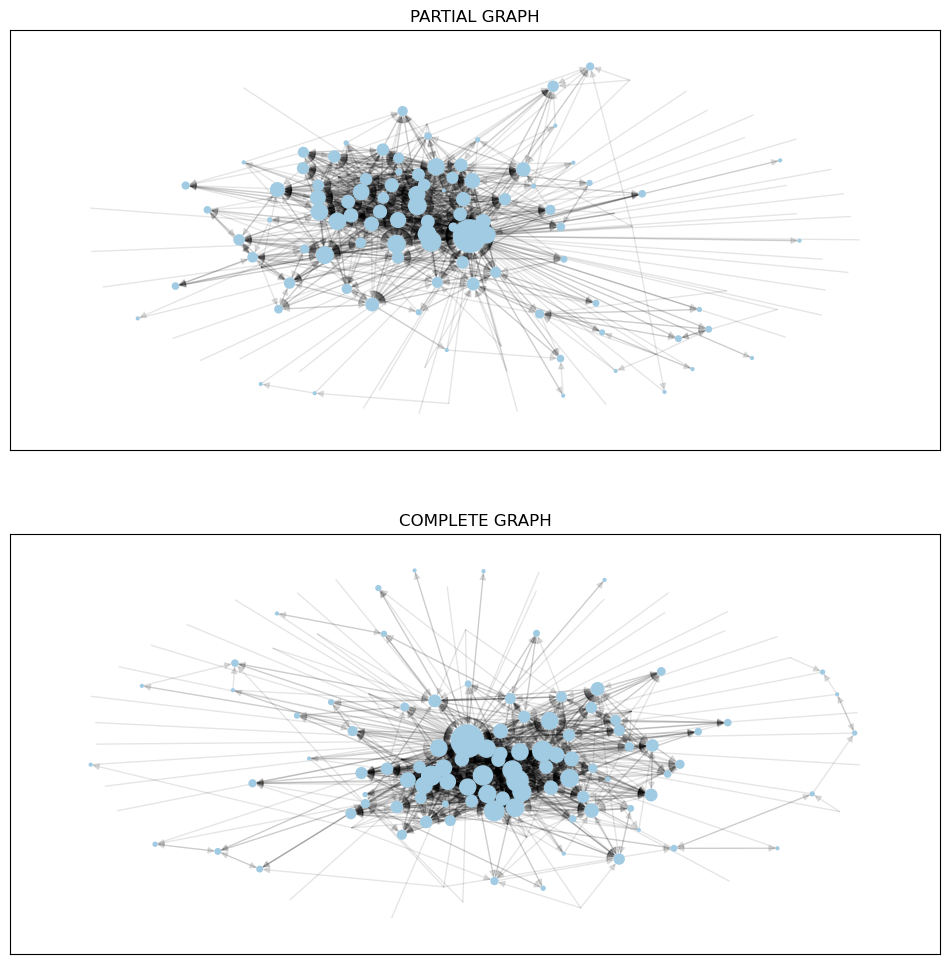

In [95]:
# Si visualizza il grafo diretto
partial_fg = nx.node_link_graph(read_json(graph_folder+"/some_users_following_graph.json"))
complete_fg = nx.node_link_graph(read_json(graph_folder+"/all_users_following_graph.json"))

# Si mostra il grafo parziale
plt.subplot(2, 1, 1)
plot_graph(partial_fg)
plt.title("PARTIAL GRAPH")

# Si mostra il grafo completo
plt.subplot(2, 1, 2)
plot_graph(complete_fg)
plt.title("COMPLETE GRAPH")

# Si salvano e si mostrano
plt.savefig(out_folder+"/following_graphs.pdf")
plt.show()

Data read from path: ./graphs/some_users_preferential_graph.json
Data read from path: ./graphs/all_users_preferential_graph.json


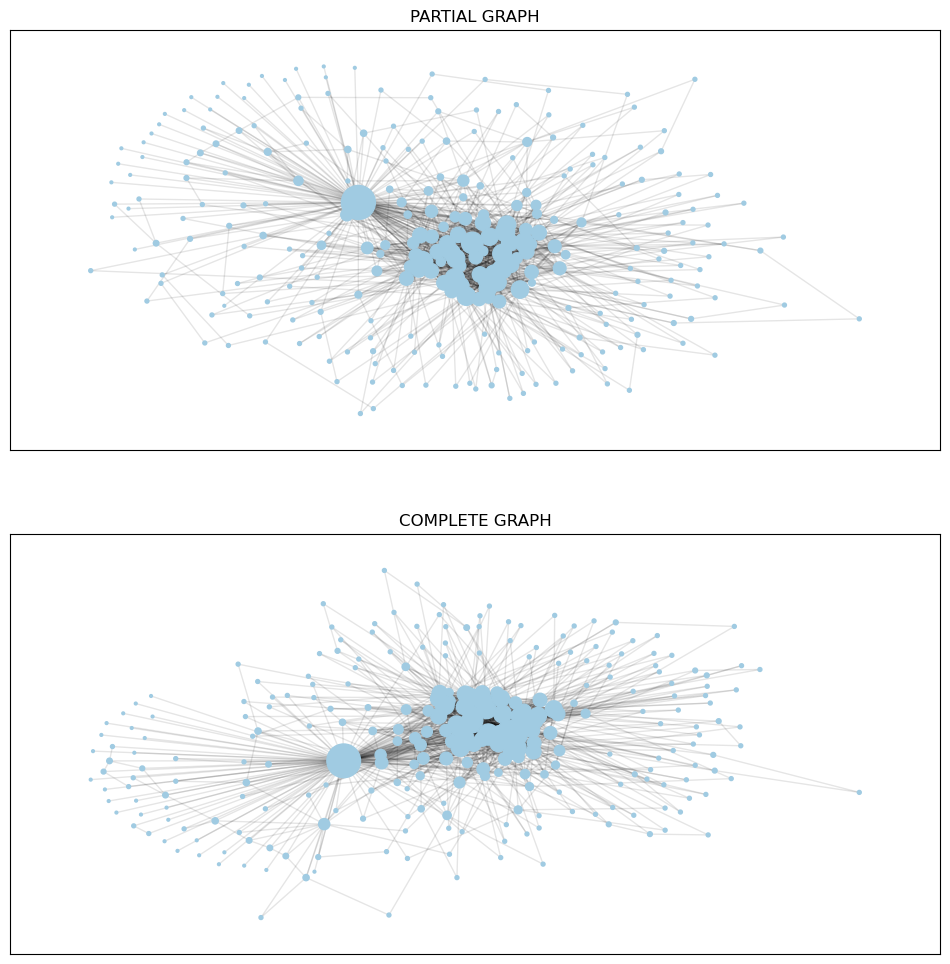

In [96]:
# Si visualizza il grafo "preferenziale"
partial_pg = nx.node_link_graph(read_json(graph_folder+"/some_users_preferential_graph.json"))
complete_pg = nx.node_link_graph(read_json(graph_folder+"/all_users_preferential_graph.json"))

# Si mostra il grafo parziale
plt.subplot(2, 1, 1)
plot_graph(partial_pg)
plt.title("PARTIAL GRAPH")

# Si mostra il grafo completo
plt.subplot(2, 1, 2)
plot_graph(complete_pg)
plt.title("COMPLETE GRAPH")

# Si salvano e si mostrano
plt.savefig(out_folder+"/preferential_graphs.pdf")
plt.show()

### Visualizzazione della più grande componente fortemente connessa

Per ciascuno dei due grafi, si produce una visualizzazione statica del grafo con una colorazione rossa dei nodi appartenenti alla più grande componente fortemente connessa (SCC), nera per gli altri.

In [97]:
def get_max_SCC_subgraph(graph):
    # identifico i nodi appartenenti alla SCC più grande
    nodes = []
    if nx.is_directed(graph):
        nodes = max(nx.strongly_connected_components(graph), key=len)
    else:
        nodes = max(nx.connected_components(graph), key=len)
    
    # Restituisco il sottografo corrispondente
    return nx.subgraph(graph, nodes)

def highlight_largest_SCC(graph):
    scc = get_max_SCC_subgraph(graph)

    # si mappa a ciascun nodo il colore appropriato
    color_map=[]
    for node in graph:
        if node in scc.nodes:
            #se il nodo fa parte della SCC più grande viene colorato di rosso
            color_map.append('red')
        else:
            #altrimenti di nero
            color_map.append('black')

    # si disegna il grafo con la mappatura definita
    plot = nx.draw_networkx(
        graph,
        pos = nx.spring_layout(graph),
        node_size = 100,
        node_color = color_map,
        edge_color = (0,0,0,0.3),
        with_labels = False
    )
    
    return plot

Data read from path: ./graphs/some_users_following_graph.json
Data read from path: ./graphs/all_users_following_graph.json


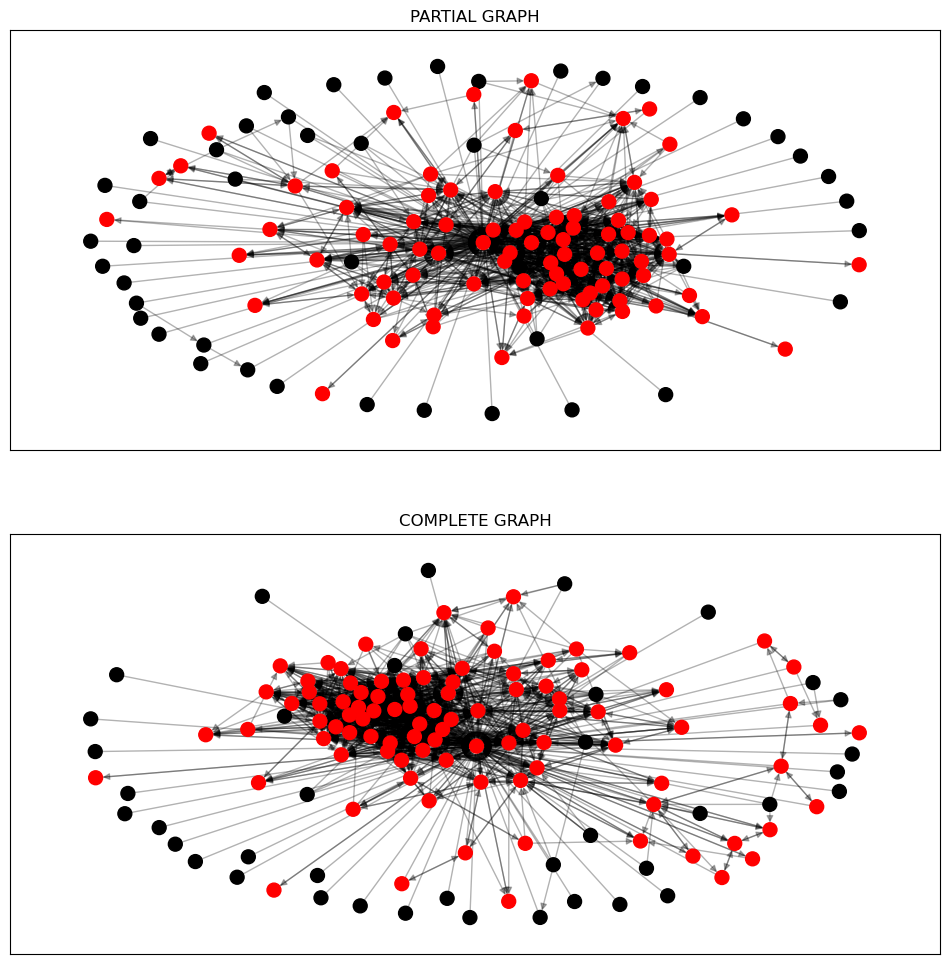

In [98]:
# Si visualizza il grafo diretto
partial_fg = nx.node_link_graph(read_json(graph_folder+"/some_users_following_graph.json"))
complete_fg = nx.node_link_graph(read_json(graph_folder+"/all_users_following_graph.json"))

# Si mostra il grafo parziale
plt.subplot(2, 1, 1)
highlight_largest_SCC(partial_fg)
plt.title("PARTIAL GRAPH")

# Si mostra il grafo completo
plt.subplot(2, 1, 2)
highlight_largest_SCC(complete_fg)
plt.title("COMPLETE GRAPH")

# Si salvano e si mostrano
plt.savefig(out_folder+"/following_graphs_SCC.pdf")
plt.show()

In [99]:
# Dimensione delle due componenti
partial_fg = nx.node_link_graph(read_json(graph_folder+"/some_users_following_graph.json"))
complete_fg = nx.node_link_graph(read_json(graph_folder+"/all_users_following_graph.json"))

dim_partial = len(list(get_max_SCC_subgraph(partial_fg).nodes()))
dim_complete = len(list(get_max_SCC_subgraph(complete_fg).nodes()))

print(f"\nDimensione SCC del grafo parziale: {dim_partial}\nDimensione SCC del grafo completo: {dim_complete}")

Data read from path: ./graphs/some_users_following_graph.json
Data read from path: ./graphs/all_users_following_graph.json

Dimensione SCC del grafo parziale: 89
Dimensione SCC del grafo completo: 96


Data read from path: ./graphs/some_users_preferential_graph.json
Data read from path: ./graphs/all_users_preferential_graph.json


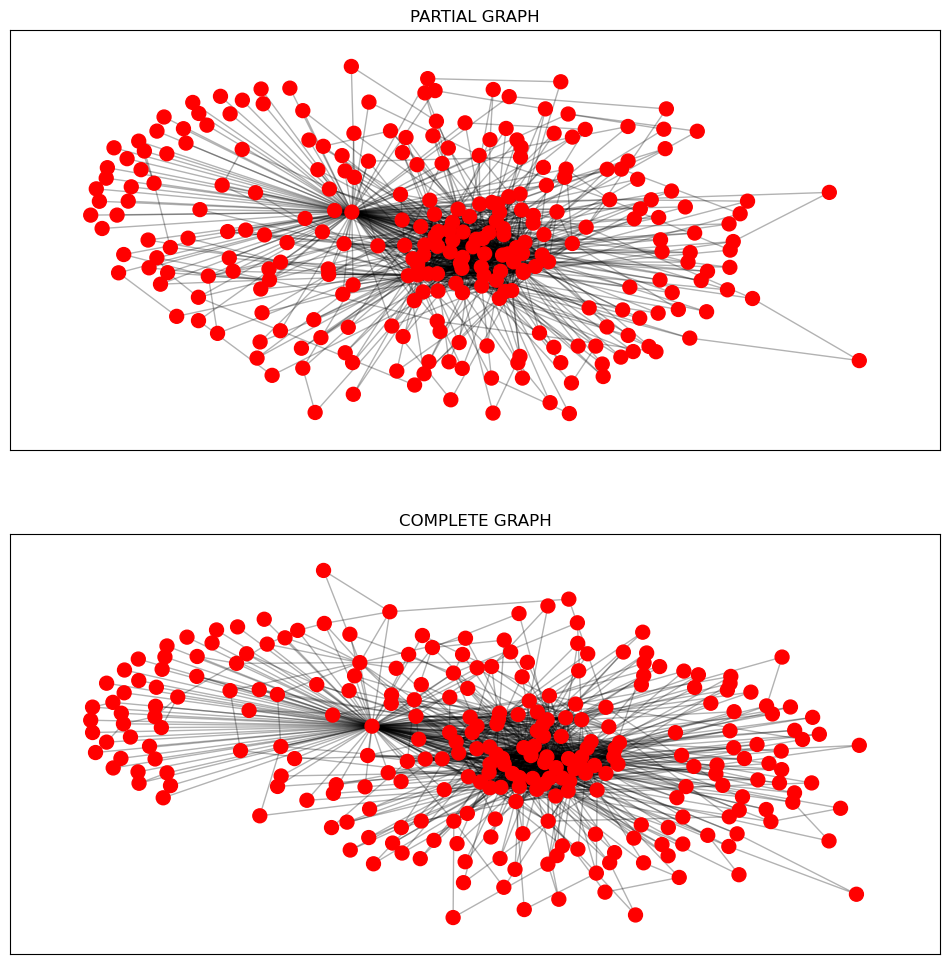

In [100]:
# Si visualizza il grafo diretto
partial_pg = nx.node_link_graph(read_json(graph_folder+"/some_users_preferential_graph.json"))
complete_pg = nx.node_link_graph(read_json(graph_folder+"/all_users_preferential_graph.json"))

# Si mostra il grafo parziale
plt.subplot(2, 1, 1)
highlight_largest_SCC(partial_pg)
plt.title("PARTIAL GRAPH")

# Si mostra il grafo completo
plt.subplot(2, 1, 2)
highlight_largest_SCC(complete_pg)
plt.title("COMPLETE GRAPH")

# Si salvano e si mostrano
plt.savefig(out_folder+"/preferential_graphs_SCC.pdf")
plt.show()

### Distanze

Si calcoleranno le seguenti distanze sui due grafi:

- il centro;
- il raggio;
- la distanza media;
- la distanza massima.

In [101]:
# Si importano i grafi rilevanti
partial_fg = nx.node_link_graph(read_json(graph_folder+"/some_users_following_graph.json"))
complete_fg = nx.node_link_graph(read_json(graph_folder+"/all_users_following_graph.json"))
partial_pg = nx.node_link_graph(read_json(graph_folder+"/some_users_preferential_graph.json"))
complete_pg = nx.node_link_graph(read_json(graph_folder+"/all_users_preferential_graph.json"))

# Si computano le massime scc per i grafi diretti
partial_scc = get_max_SCC_subgraph(partial_fg)
complete_scc = get_max_SCC_subgraph(complete_fg)

# si prepara un dizionario delle distanze
distances = {}

#centro
distances["center"] = [
    list(nx.center(partial_scc)),
    list(nx.center(complete_scc)),
    list(nx.center(partial_pg)),
    list(nx.center(complete_pg))
]
#raggio
distances["radius"] = [
    nx.radius(partial_scc),
    nx.radius(complete_scc),
    nx.radius(partial_pg),
    nx.radius(complete_pg)
]
#distanza media
distances["avarage_distance"] = [
    nx.average_shortest_path_length(partial_fg),
    nx.average_shortest_path_length(complete_fg),
    nx.average_shortest_path_length(partial_pg),
    nx.average_shortest_path_length(complete_pg)
]
#distanza massima 
distances["max_distance"] = [
    nx.diameter(partial_scc),
    nx.diameter(complete_scc),
    nx.diameter(partial_pg),
    nx.diameter(complete_pg)
]

# si visualizzano le distanze attraverso una tabella
pd.DataFrame(distances, index=["partial_fg", "complete_fg", "partial_pg", "complete_pg"])

Data read from path: ./graphs/some_users_following_graph.json
Data read from path: ./graphs/all_users_following_graph.json
Data read from path: ./graphs/some_users_preferential_graph.json
Data read from path: ./graphs/all_users_preferential_graph.json


,center,radius,avarage_distance,max_distance
partial_fg,"[3036907250, 28607182, 1546349170315120640, 15...",3,1.370370,4
complete_fg,"[3051698888, 1734817550, 3037264899, 2827812417]",4,1.546569,7
partial_pg,"[3036907250, 203070657, 998681467696885761, 12...",3,2.560044,5
complete_pg,"[3036907250, 203070657, 998681467696885761, 28...",3,2.545149,5


### Calcolo delle misure di centralità

Si vogliono calcolare le seguenti metriche inerenti alla centralità dei due grafi:
- centralità di betweenness;
- centralità di prossimità;
- centralità di grado (in entrata/uscita);
- PageRank;
- HITS.

In [102]:
# Si definisce una funzione per restituire la lista di valori di un dizionario
def to_list(dict):
    return list(dict.values())

# Si definisce una funzione che compone un dizionario con le metriche di centralità rilevanti
def compute_centrality_metrics(graph):
    metrics = {}
    # Betweenness
    metrics["betweenness"] = to_list(nx.betweenness_centrality(graph))
    # Closeness
    metrics["closeness"] = to_list(nx.closeness_centrality(graph))
    # (in/out-)degree
    if(nx.is_directed(graph)):
        metrics["in_degree"] = to_list(nx.in_degree_centrality(graph))
        metrics["out_degree"] = to_list(nx.out_degree_centrality(graph))
    else:
        metrics["degree"] = to_list(nx.degree_centrality(graph))
    # PageRank
    metrics["pagerank"] = to_list(nx.pagerank(graph))
    # HITS
    metrics["hits"] = to_list(nx.hits(graph)[0])

    return metrics

In [103]:
# si importano i due grafi
partial_fg = nx.node_link_graph(read_json(graph_folder+"/some_users_following_graph.json"))
complete_fg = nx.node_link_graph(read_json(graph_folder+"/all_users_following_graph.json"))
partial_pg = nx.node_link_graph(read_json(graph_folder+"/some_users_preferential_graph.json"))
complete_pg = nx.node_link_graph(read_json(graph_folder+"/all_users_preferential_graph.json"))

# si calcolano le metriche di centralità per i due grafi
partial_fg_centrality = compute_centrality_metrics(partial_fg)
complete_fg_centrality = compute_centrality_metrics(complete_fg)
partial_pg_centrality = compute_centrality_metrics(partial_pg)
complete_pg_centrality = compute_centrality_metrics(complete_pg)

# si mostrano le metriche calcolate sotto forma di tabella
print("Grafo diretto parziale")
print(pd.DataFrame(partial_fg_centrality, index=partial_fg.nodes()).describe())
print("Grafo diretto completo")
print(pd.DataFrame(complete_fg_centrality, index=complete_fg.nodes()).describe())
print("Grafo \"preferenziale\" parziale")
print(pd.DataFrame(partial_pg_centrality, index=partial_pg.nodes()).describe())
print("Grafo \"preferenziale\" completo")
print(pd.DataFrame(complete_pg_centrality, index=complete_pg.nodes()).describe())


Data read from path: ./graphs/some_users_following_graph.json
Data read from path: ./graphs/all_users_following_graph.json
Data read from path: ./graphs/some_users_preferential_graph.json
Data read from path: ./graphs/all_users_preferential_graph.json


c:\Users\stefa\anaconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


Grafo diretto parziale
       betweenness   closeness   in_degree  out_degree    pagerank        hits
count   136.000000  136.000000  136.000000  136.000000  136.000000  136.000000
mean      0.005341    0.324690    0.073965    0.073965    0.007353    0.007353
std       0.035030    0.248321    0.115204    0.079233    0.010852    0.006687
min       0.000000    0.000000    0.000000    0.007407    0.001103    0.001756
25%       0.000000    0.000000    0.000000    0.007407    0.001103    0.001756
50%       0.000095    0.416049    0.029630    0.044444    0.003893    0.004239
75%       0.002774    0.529412    0.118519    0.118519    0.009996    0.012147
max       0.405846    1.000000    1.000000    0.474074    0.105769    0.029725
Grafo diretto completo
       betweenness   closeness   in_degree  out_degree    pagerank        hits
count   136.000000  136.000000  136.000000  136.000000  136.000000  136.000000
mean      0.006273    0.348118    0.087092    0.087092    0.007353    0.007353
std   

### Coefficenti per la stima della "small-worldness" 

I coefficienti per la "small-worldness" del grafo indiretto sono:

- il coefficiente omega;
- il coefficiente sigma.

In [104]:
preferential_graph = nx.node_link_graph(read_json(graph_folder+"/preferential_graph.json"))

# si calcolano i valori
omega_value = nx.omega(preferential_graph)
sigma_value = nx.sigma(preferential_graph)

print(f"Coefficiente omega: {omega_value}\nCoefficiente sigma: {sigma_value}")

No data found at path: ./graphs/preferential_graph.json


KeyError: 'nodes'